### Multi-layer Perceptron (MLP)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [9]:
df = pd.read_csv('dataset_final_para_modelo.csv', decimal=',')

In [10]:
# Seleciona as features finais (numéricas)
y = df['Sinistro']
X = df.drop(columns=['Sinistro', 'data'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=8, stratify=y
)

X_train['tipo_via_num'] = X_train['tipo_via_num'].fillna(-1)
X_test['tipo_via_num'] = X_test['tipo_via_num'].fillna(-1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=8) # Aumenta artificialmente o número de amostras da classe minoritária
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic', 'identity'],
    'alpha': [0.0001, 0.001, 0.01], # Diferentes níveis de regularização
    'learning_rate_init': [0.001, 0.01] # Diferentes taxas de aprendizagem
}

mlp = MLPClassifier(
    solver='adam',
    max_iter=500, # Dê tempo suficiente para convergir
    random_state=8,
    early_stopping=True,
    n_iter_no_change=10
    )

grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp,
    scoring='f1',
    cv=3, # Validação Cruzada com 3 folds de mistura do conjunto de teste e treino
    verbose=2,
    n_jobs=-1
)

# 4. Execute a busca (A PARTE MAIS DEMORADA)
print("Iniciando o GridSearchCV para MLP (isto vai demorar MUITO)...")
grid_search_mlp.fit(X_train_scaled, y_train)
print("GridSearchCV para MLP concluído.")

# 5. Veja os melhores parâmetros encontrados
print("\nMelhores parâmetros encontrados para MLP:")
print(grid_search_mlp.best_params_)

# 6. Veja a melhor pontuação F1-Score (ou AUC)
print("\nMelhor pontuação (validação cruzada):")
print(grid_search_mlp.best_score_)

# 7. Avalie o melhor modelo encontrado no conjunto de teste
best_mlp_model = grid_search_mlp.best_estimator_
y_pred_best_mlp = best_mlp_model.predict(X_test_scaled)
# (Calcule e imprima o classification_report e a AUC aqui)

Iniciando o GridSearchCV para MLP (isto vai demorar MUITO)...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
GridSearchCV para MLP concluído.

Melhores parâmetros encontrados para MLP:
{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01}

Melhor pontuação (validação cruzada):
0.7092815900843267


In [6]:
#    hidden_layer_sizes=(100, 50): Define a arquitetura - duas camadas ocultas, a 1ª com 100 neurónios, a 2ª com 50.
#    activation='relu': Função de ativação comum e eficaz.
#    solver='adam': O otimizador padrão e geralmente bom.
#    alpha=0.0001: Termo de regularização L2 para evitar overfitting.
#    max_iter=500: Número máximo de épocas de treino.
#    random_state=8: Para reprodutibilidade.
#    early_stopping=True: Para o treino se a performance não melhorar, evitando overfitting.
print("Inicializando o modelo MLP...")
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    max_iter=500,
    random_state=8,
    early_stopping=True, # Importante para evitar overfitting
    n_iter_no_change=10 # Número de iterações sem melhora antes de parar
)

# 2. Treina o modelo com os dados ESCALONADOS
print("Treinando o modelo MLP (pode demorar)...")
mlp_model.fit(X_train_resampled, y_train_resampled)
print("Treinamento concluído.")

Inicializando o modelo MLP...
Treinando o modelo MLP (pode demorar)...
Treinamento concluído.



--- Avaliação do Modelo MLP ---

--- Matriz de Confusão (MLP) ---

--- Relatório de Classificação (MLP) ---
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      4914
           1       0.93      0.59      0.72      2457

    accuracy                           0.85      7371
   macro avg       0.88      0.78      0.81      7371
weighted avg       0.86      0.85      0.84      7371

--- AUC (MLP) ---
0.8549


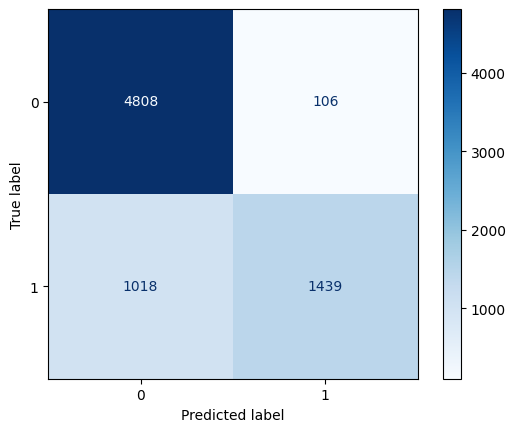

In [11]:
# 3. Faz as previsões e avalia, usando os dados de teste ESCALONADOS
print("\n--- Avaliação do Modelo MLP ---")
y_pred_mlp = mlp_model.predict(X_test_scaled)

print("\n--- Matriz de Confusão (MLP) ---")
cm = confusion_matrix(y_test, y_pred_mlp)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)

print("\n--- Relatório de Classificação (MLP) ---")
print(classification_report(y_test, y_pred_mlp))

# Calcula a AUC (requer probabilidades)
y_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]
auc_mlp = roc_auc_score(y_test, y_prob_mlp)
print(f"--- AUC (MLP) ---")
print(f"{auc_mlp:.4f}")

In [12]:
#    hidden_layer_sizes=(100, 50): Define a arquitetura - duas camadas ocultas, a 1ª com 100 neurónios, a 2ª com 50.
#    activation='relu': Função de ativação comum e eficaz.
#    solver='adam': O otimizador padrão e geralmente bom.
#    alpha=0.0001: Termo de regularização L2 para evitar overfitting.
#    max_iter=500: Número máximo de épocas de treino.
#    random_state=8: Para reprodutibilidade.
#    early_stopping=True: Para o treino se a performance não melhorar, evitando overfitting.
print("Inicializando o modelo MLP...")
mlp_model = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation='logistic',
    solver='adam',
    alpha=0.01,
    max_iter=500,
    random_state=8,
    early_stopping=True, # Importante para evitar overfitting
    n_iter_no_change=10, # Número de iterações sem melhora antes de parar
    learning_rate_init=0.01
)

# 2. Treina o modelo com os dados ESCALONADOS
print("Treinando o modelo MLP (pode demorar)...")
mlp_model.fit(X_train_resampled, y_train_resampled)
print("Treinamento concluído.")

Inicializando o modelo MLP...
Treinando o modelo MLP (pode demorar)...
Treinamento concluído.



--- Avaliação do Modelo MLP ---

--- Matriz de Confusão (MLP) ---

--- Relatório de Classificação (MLP) ---
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      4914
           1       0.82      0.63      0.71      2457

    accuracy                           0.83      7371
   macro avg       0.83      0.78      0.80      7371
weighted avg       0.83      0.83      0.82      7371

--- AUC (MLP) ---
0.8537


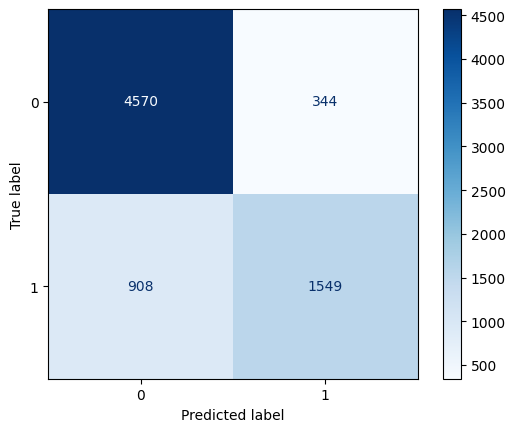

In [13]:
# 3. Faz as previsões e avalia, usando os dados de teste ESCALONADOS
print("\n--- Avaliação do Modelo MLP ---")
y_pred_mlp = mlp_model.predict(X_test_scaled)

print("\n--- Matriz de Confusão (MLP) ---")
cm = confusion_matrix(y_test, y_pred_mlp)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)

print("\n--- Relatório de Classificação (MLP) ---")
print(classification_report(y_test, y_pred_mlp))

# Calcula a AUC (requer probabilidades)
y_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]
auc_mlp = roc_auc_score(y_test, y_prob_mlp)
print(f"--- AUC (MLP) ---")
print(f"{auc_mlp:.4f}")

--- PR AUC ---
0.8280


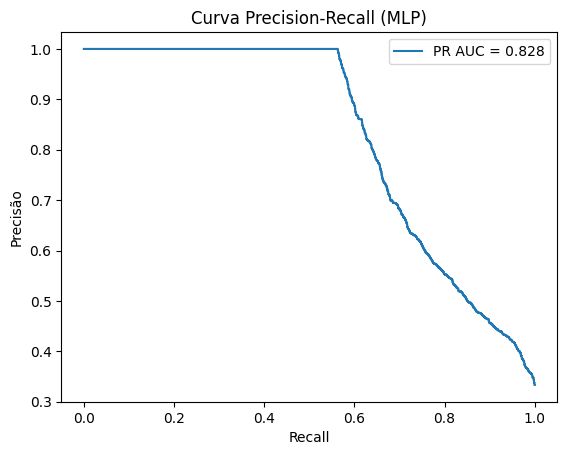

In [14]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Calcula as probabilidades positivas
y_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]

# Calcula precisão, recall e PR AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob_mlp)
pr_auc = auc(recall, precision)

print(f"--- PR AUC ---\n{pr_auc:.4f}")

# Plota a curva Precision-Recall
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall (MLP)')
plt.legend()
plt.show()
